# Compare performances between different experiments

- compare ROC curves / PR curves between e.g. different variable selections or datasets

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_imputeScale import pipe_imputation_scaling, pipe_supervisedSelector
from func_preprocess import read_data, subset_wo_missigness, remove_NA, parseVariables, clean_data, impute_scale 
import shap
import pickle

from sklearn.pipeline import Pipeline

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score, average_precision_score, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Analyse scores - Full Registry

In [2]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "partially validated: 6 vars":"fullRegistry/partiallyValidated",
    "fullRegistry: 7 vars":"fullRegistry/gender_bootstrapped_iterativeBoruta_100perc",
    #"fullRegistry: 11 vars":"fullRegistry/gender_bootstrapped_iterativeBoruta_80perc",
    

}


In [3]:
#### Merge dataframes to plot

df_all = pd.DataFrame()
for k,v in dic_varSets.items():
    resultsPath = f"{PATH}/results/30_internalValidation/{v}"
    df = pd.read_csv(f"{resultsPath}/summary_scores.csv", index_col=0)
    df["varSet"] = k
    df_all = pd.concat([df_all, df], axis=0)

df_all = df_all.drop(["brier"], axis=1)

Text(0.5, 0, 'ROC-AUC')

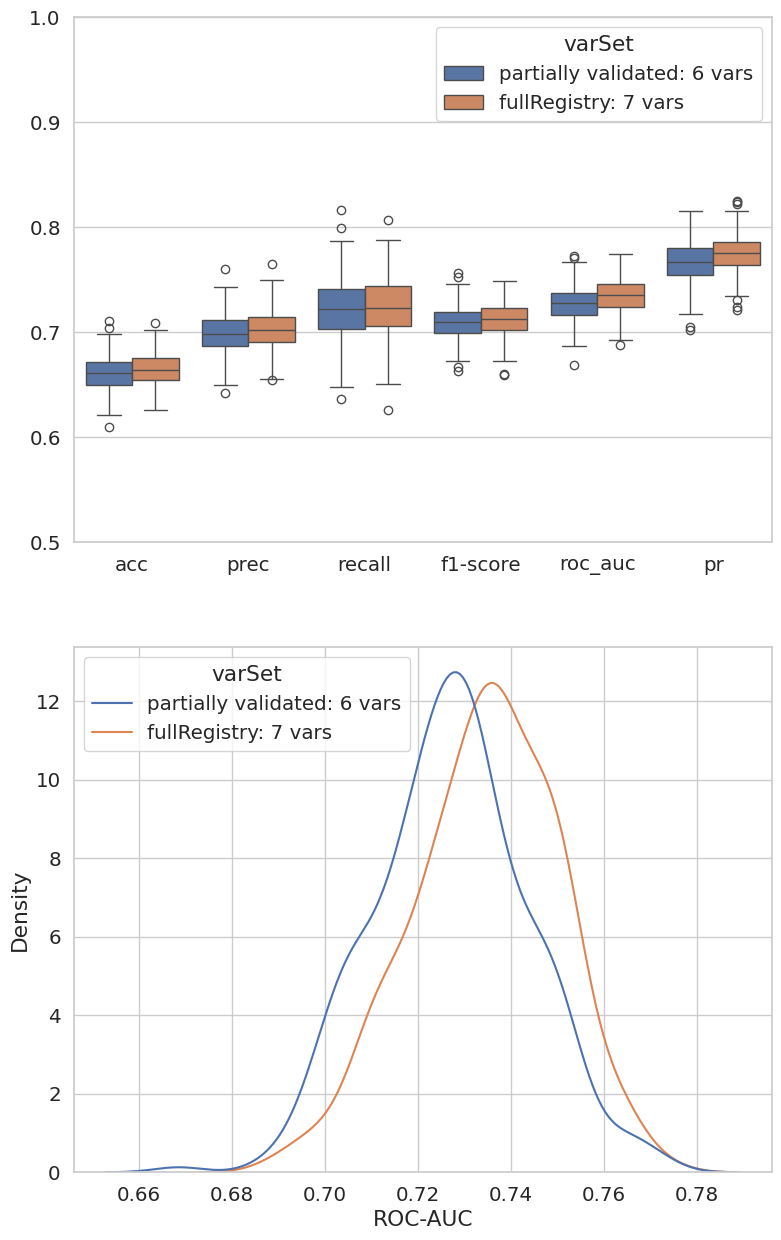

In [4]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(9,15))

tmp = df_all.melt(["varSet"])
sns.boxplot(data=tmp, x= "variable", y="value", hue="varSet", ax=ax1)
ax1.set_ylim(0.5,1)
ax1.set_xlabel("")
ax1.set_ylabel("")

tmp2 = df_all.loc[:,["roc_auc", "varSet"]].melt(["varSet"])
sns.kdeplot(data=tmp2, x="value", hue="varSet", ax=ax2)
ax2.set_xlabel("ROC-AUC")

## ROC AUC curves

In [15]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    #"15vars":"manual_selection/clusterVariables_allVars",
    # "clusterVariables: 5 vars":"clusterVariables_boruta/gender_bootstrapped_iterativeBoruta_100perc",
    # "clusterVariables: 7 vars":"clusterVariables_boruta/gender_bootstrapped_iterativeBoruta_80perc",
    # "fullRegistry: 7 vars":"fullRegistry_boruta/gender_bootstrapped_iterativeBoruta_100perc",
    # "fullRegistry: 11 vars":"fullRegistry_boruta/gender_bootstrapped_iterativeBoruta_80perc",
    "partially validated: 6 vars":"fullRegistry/partiallyValidated",
    "fullRegistry: 7 vars":"fullRegistry/gender_bootstrapped_iterativeBoruta_100perc",
    #"fullRegistry: 11 vars":"fullRegistry/gender_bootstrapped_iterativeBoruta_80perc",

}


In [19]:
''' Load data for curve 1 '''
n_iter = 300
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[0]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary = pickle.load(f)


''' Load data for curve 2 '''
n_iter = 300
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[1]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_c2 = pickle.load(f)

# ''' Load data for curve 2 '''
# n_iter = 300
# resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[2]}"
# with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
#     dic_summary_c3 = pickle.load(f)


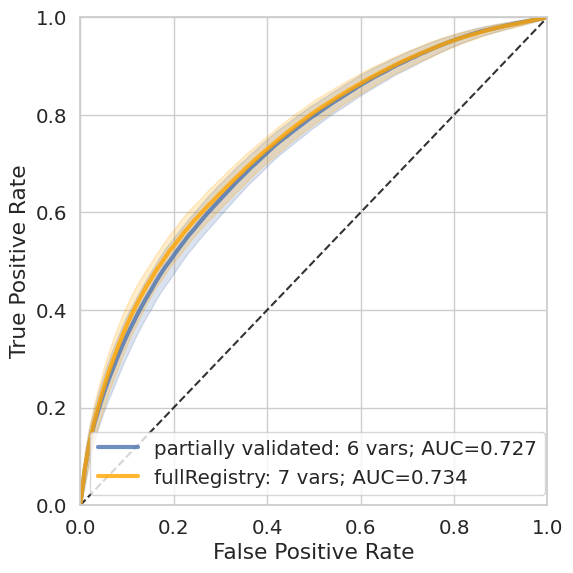

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
mean_fpr = np.linspace(0, 1, 100)


''' Development '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)  #tprs[5]
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=f"Development; AUC=0.828 \n(95%CI 0.763, 0.883)",
    label=f"{list(dic_varSets.keys())[0]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
    label="",
)    


''' Curve 2 '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="orange",
    label=f"{list(dic_varSets.keys())[1]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="orange",
    alpha=0.2,
    label="",
)    


# ''' Curve 3 '''
# tprs = []
# fpr = pd.DataFrame.from_dict(dic_summary_c3).T.loc[:,"fpr"]
# tpr = pd.DataFrame.from_dict(dic_summary_c3).T.loc[:,"tpr"]
# for i in range(fpr.shape[0]):
#     interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)

# mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0
# ax.plot(
#     mean_fpr,
#     mean_tpr,
#     color="green",
#     label=f"{list(dic_varSets.keys())[2]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
#     lw=3,
#     alpha=0.8,
# )
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# ax.fill_between(
#     mean_fpr,
#     tprs_lower,
#     tprs_upper,
#     color="green",
#     alpha=0.2,
#     label="",
# )    




''' General '''
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", alpha=.8, zorder=1)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.tight_layout()


#plt.savefig(f"{folderFigures}/ROC_curves.png", dpi=300)
# plt.savefig(f"{folderFigures}/ROC_curves.pdf", dpi=300)



# Analyse scores - natural

In [11]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "natural: 5 vars":"natural/gender_bootstrapped_iterativeBoruta_100perc",
    #"natural: all vars":"natural/allVariables",
    "fullRegistry: 7 vars":"fullRegistry/gender_bootstrapped_iterativeBoruta_100perc",
}


In [12]:
#### Merge dataframes to plot

df_all = pd.DataFrame()
for k,v in dic_varSets.items():
    resultsPath = f"{PATH}/results/30_internalValidation/{v}"
    df = pd.read_csv(f"{resultsPath}/summary_scores.csv", index_col=0)
    df["varSet"] = k
    df_all = pd.concat([df_all, df], axis=0)

df_all = df_all.drop(["brier"], axis=1)

Text(0, 0.5, '')

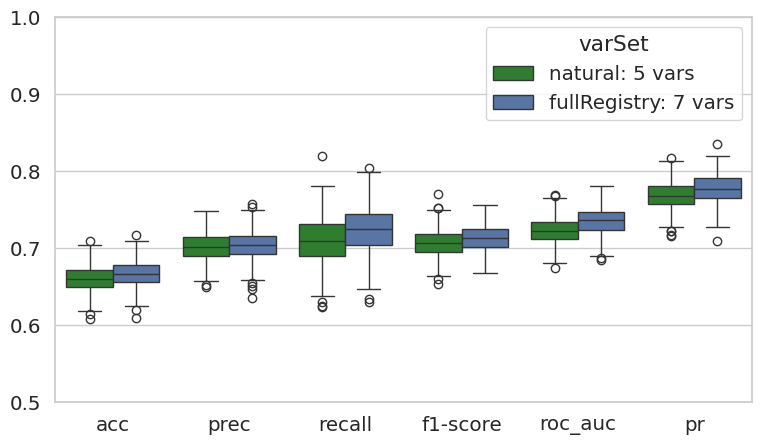

In [16]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, (ax1) = plt.subplots(1,1,figsize=(9,5))


my_pal = {"natural: 5 vars": "forestgreen", "fullRegistry: 7 vars": "b"}

tmp = df_all.melt(["varSet"])
sns.boxplot(data=tmp, x= "variable", y="value", hue="varSet", ax=ax1, palette = my_pal)
ax1.set_ylim(0.5,1)
ax1.set_xlabel("")
ax1.set_ylabel("")

# tmp2 = df_all.loc[:,["roc_auc", "varSet"]].melt(["varSet"])
# sns.kdeplot(data=tmp2, x="value", hue="varSet", ax=ax2)
# ax2.set_xlabel("ROC-AUC")

## ROC AUC curves

In [5]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "natural: 5 vars":"natural/gender_bootstrapped_iterativeBoruta_100perc",
    #"natural: all vars":"natural/allVariables",
    "fullRegistry: 7 vars":"fullRegistry/gender_bootstrapped_iterativeBoruta_100perc",
}



In [6]:
''' Load data for curve 1 '''
n_iter = 300
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[0]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary = pickle.load(f)


''' Load data for curve 2 '''
n_iter = 300
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[1]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_c2 = pickle.load(f)

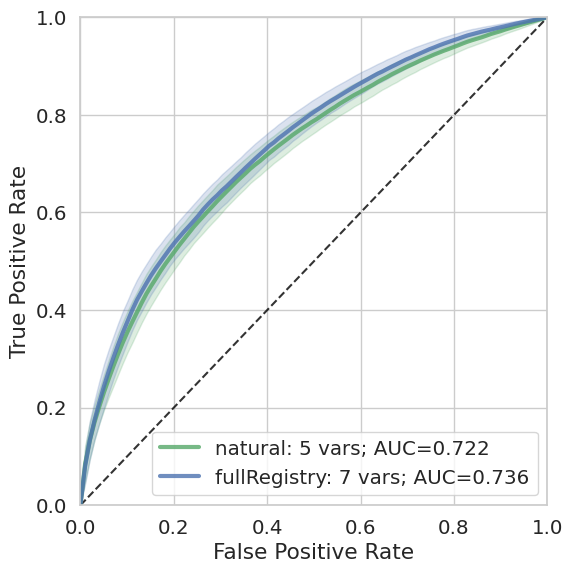

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
mean_fpr = np.linspace(0, 1, 100)


''' Development '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)  #tprs[5]
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="g",
    #label=f"Development; AUC=0.828 \n(95%CI 0.763, 0.883)",
    label=f"{list(dic_varSets.keys())[0]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="g",
    alpha=0.2,
    label="",
)    


''' Curve 2 '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=f"{list(dic_varSets.keys())[1]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
    label="",
)    






''' General '''
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", alpha=.8, zorder=1)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.tight_layout()


# plt.savefig(f"{folderFigures}/ROC_curves.png", dpi=300)
# plt.savefig(f"{folderFigures}/ROC_curves.pdf", dpi=300)



# Analyse scores - histo subgrpup

In [35]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "histo: 7 variables":"histologie_subgroup/gender_bootstrapped_iterativeBoruta_80perc",
    "force histo in":"histologie_subgroup/forceHisto",
    "only histo":"histologie_subgroup/onlyHisto",
}


In [36]:
#### Merge dataframes to plot

df_all = pd.DataFrame()
for k,v in dic_varSets.items():
    resultsPath = f"{PATH}/results/30_internalValidation/{v}"
    df = pd.read_csv(f"{resultsPath}/summary_scores.csv", index_col=0)
    df["varSet"] = k
    df_all = pd.concat([df_all, df], axis=0)

df_all = df_all.drop(["brier"], axis=1)

Text(0, 0.5, '')

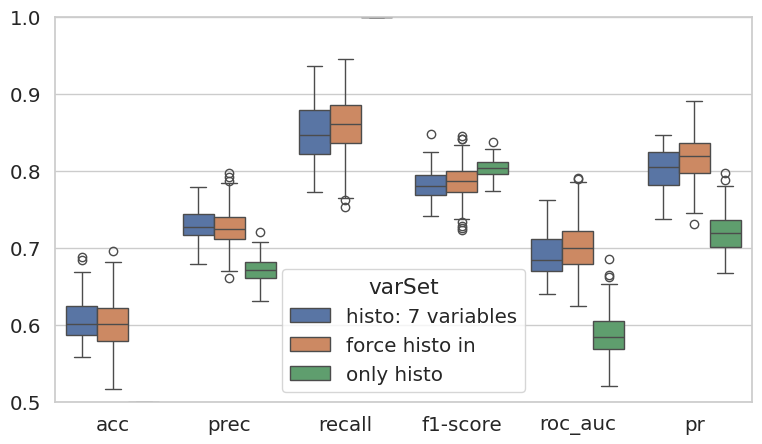

In [37]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, (ax1) = plt.subplots(1,1,figsize=(9,5))

tmp = df_all.melt(["varSet"])
sns.boxplot(data=tmp, x= "variable", y="value", hue="varSet", ax=ax1)
ax1.set_ylim(0.5,1)
ax1.set_xlabel("")
ax1.set_ylabel("")

# tmp2 = df_all.loc[:,["roc_auc", "varSet"]].melt(["varSet"])
# sns.kdeplot(data=tmp2, x="value", hue="varSet", ax=ax2)
# ax2.set_xlabel("ROC-AUC")

## ROC AUC curves

In [46]:
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


### structure:  varSet: vars
dic_varSets = {  
    "Boruta: 7 variables":"histologie_subgroup/gender_bootstrapped_iterativeBoruta_80perc",
    "force histo in":"histologie_subgroup/forceHisto",
    "only histo":"histologie_subgroup/onlyHisto",
}



In [47]:
''' Load data for curve 1 '''
n_iter = 50
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[0]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary = pickle.load(f)


''' Load data for curve 2 '''
n_iter = 300
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[1]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_c2 = pickle.load(f)

    ''' Load data for curve 2 '''
n_iter = 50
resultsPath = f"{PATH}/results/30_internalValidation/{list(dic_varSets.values())[2]}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_c3 = pickle.load(f)

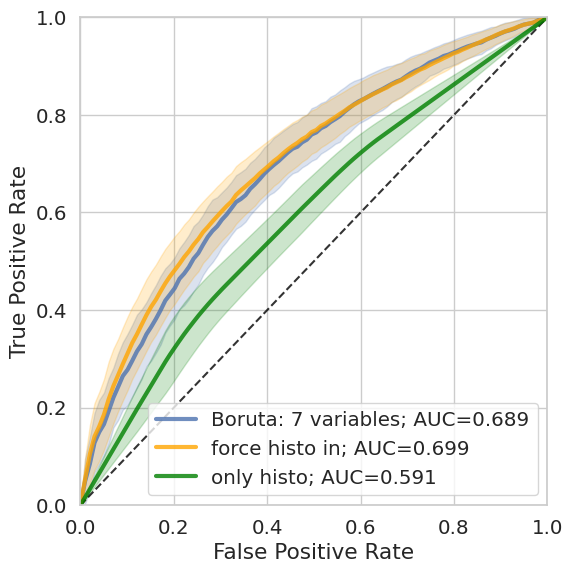

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
mean_fpr = np.linspace(0, 1, 100)


''' Development '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)  #tprs[5]
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=f"Development; AUC=0.828 \n(95%CI 0.763, 0.883)",
    label=f"{list(dic_varSets.keys())[0]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
    label="",
)    


''' Curve 2 '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_c2).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="orange",
    label=f"{list(dic_varSets.keys())[1]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="orange",
    alpha=0.2,
    label="",
)    


''' Curve 3 '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary_c3).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_c3).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="green",
    label=f"{list(dic_varSets.keys())[2]}; AUC={round(auc(mean_fpr, mean_tpr), 3)}",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="green",
    alpha=0.2,
    label="",
)    




''' General '''
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", alpha=.8, zorder=1)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.tight_layout()


# plt.savefig(f"{folderFigures}/ROC_curves.png", dpi=300)
# plt.savefig(f"{folderFigures}/ROC_curves.pdf", dpi=300)

